In [1]:
import pandas as pd
import numpy as np
import pyodbc

import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import gridspec
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns; sns.set()
from statsmodels import robust
import statistics

from datetime import datetime
from datetime import timedelta  
import os
import random

In [2]:
data_customers=pd.read_csv('data_customers.csv',sep=',')
data_accounts=pd.read_csv('data_accounts.csv',sep=',')
payments=pd.read_csv('payments.csv',sep=',')
sche_payments=pd.read_csv('sche_payments.csv',sep=',')
code=pd.read_csv('code.csv',sep=',')

## Functions

In [3]:
##### function for plotting and first dataframe base

def plot(OID,Start_date,End_date):
    Start_date=datetime.strptime(Start_date, '%Y-%m-%d')
    End_date=datetime.strptime(End_date, '%Y-%m-%d')
    payment=payment_customer[(payment_customer.Cus_OID==OID)&((payment_customer.Pay_Date>=Start_date)&
                (payment_customer.Pay_Date<=End_date))][['Pay_Date','Pay_Total_payment','Cod_type']]
    schedule=sche_payment_customer[(sche_payment_customer.Cus_OID==OID)&((sche_payment_customer.Sche_Date>=Start_date)&
                (sche_payment_customer.Sche_Date<=End_date))][['Sche_Date','Sche_Total_payment','Cod_type']]

    payment=payment.groupby(['Pay_Date','Cod_type'])['Pay_Total_payment'].agg(Pay_Total_payment='sum')
    payment.reset_index(inplace=True)
    payment.columns = ['Date', 'Cod','Amount']
    schedule=schedule.groupby(['Sche_Date','Cod_type'])['Sche_Total_payment'].agg(Sche_Total_payment='sum')
    schedule.reset_index(inplace=True)
    schedule.columns = ['Date', 'Cod','Amount']
    main_table=pd.concat([payment,schedule])
    main_table=main_table.pivot_table('Amount', ['Date'], 'Cod')
    main_table.reset_index(inplace=True)
    ## creating a time vector
    datex=Start_date
    datelist=list()
    while datex<=End_date:
        datelist.append(datex)
        datex+= timedelta(days=1)  
    datelist
    Dates={'Dates':datelist} 
    Dates=pd.DataFrame(Dates)
    ##merging time vector and main table
    main_table=pd.merge(left=Dates,right=main_table,how='outer',left_on='Dates', right_on='Date')[['Dates','efect','pres']]
    main_table.fillna(0, inplace=True)
    #creating errors plot
    main_table['dev']=main_table['pres']-main_table['efect']
    
    fig = plt.figure(figsize=(12, 6))
    grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
    main_ax = fig.add_subplot(grid[:-1, 1:])
    y_hist = fig.add_subplot(grid[:-1, 0], yticklabels=[])
    x_hist = fig.add_subplot(grid[-1, 1:],xticklabels=[])

    main_ax.bar(main_table['Dates'], main_table['efect'], align='center', alpha=0.8,color='b',label='Actual Payment')
    main_ax.bar(main_table['Dates'], main_table['pres'], align='center', alpha=0.4,color='r',label='Due Payment')
    main_ax.legend()
    main_ax.xaxis.set_tick_params(labelsize=5)
    main_ax.yaxis.set_tick_params(labelsize=7)
    y_hist.hist(main_table['efect'], bins=10,orientation='horizontal',label='Payment Distribution')
    y_hist.legend(prop={"size":9},loc=2)
    y_hist.invert_xaxis()
    x_hist.plot(main_table['Dates'], main_table['dev'],color='b',linewidth=0.5,label='Payment deviation')
    x_hist.legend()
    x_hist.axhline(y=0.5, color='r', linewidth=0.5,alpha=0.8,linestyle='-')
    plt.tight_layout()
    return plt.show

def logistic_formula(x):
    L=6
    K=1
    e=np.exp(1)
    a=-1
    Int=3
    y=(L/(1+K*e**(a*x)))-Int
    return y

## Data manipulation.

In [4]:
#merging.
account_customer=pd.merge(left=data_accounts,right=data_customers,how='inner',left_on='Cus_ID', right_on='Cus_ID')

payment_customer=pd.merge(left=payments,right=data_customers,how='inner',left_on='Cus_ID', right_on='Cus_ID')
payment_customer=pd.merge(left=payment_customer,right=code,how='inner',left_on='Cod_ID', right_on='Nor')

sche_payment_customer=pd.merge(left=sche_payments,right=data_customers,how='inner',left_on='Cus_ID', right_on='Cus_ID')
sche_payment_customer=pd.merge(left=sche_payment_customer,right=code,how='inner',left_on='Cod_ID', right_on='Nor')

#formating dates
account_customer.Acc_Start_date=pd.to_datetime(account_customer.Acc_Start_date, format="%Y-%m-%d")
account_customer.Acc_Mat_date=pd.to_datetime(account_customer.Acc_Mat_date, format="%Y-%m-%d")

payment_customer.Pay_Date=pd.to_datetime(payment_customer.Pay_Date, format="%Y-%m-%d")
sche_payment_customer.Sche_Date=pd.to_datetime(sche_payment_customer.Sche_Date, format="%Y-%m-%d")


## descriptive data

In [5]:
list_names=['Data Customer','Accounts','Payments','Due Payments']
list_rows=[data_customers.shape[0],data_accounts.shape[0],payments.shape[0],sche_payments.shape[0]]
list_list={'Table':list_names,'N. Rows':list_rows}
pd.DataFrame(data=list_list)

,Table,N. Rows
0,Data Customer,4522
1,Accounts,25687
2,Payments,639357
3,Due Payments,500360


In [6]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
num_lista=list(data_customers.select_dtypes(include=numerics).columns)
lista=list(data_customers.columns)

vector=[]
for col in lista:
    if col in num_lista:
        vector.append('Numeric Column')
    else:
        vector.append(list(data_customers[col].unique()))
        
data={'Columns':lista,'Type or Sample':vector}
pd.DataFrame(data=data)

,Columns,Type or Sample
0,Cus_ID,Numeric Column
1,Cus_OID,Numeric Column
2,Agency,"[D, E, F, G, C, H, I, A, B]"
3,Zone,Numeric Column
4,cli_id,Numeric Column
5,Sex,"[F, M]"
6,Marital_Status,"[S, C, O]"
7,age,Numeric Column


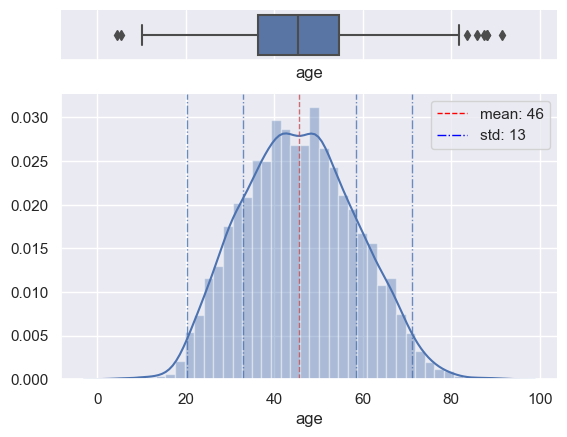

In [7]:
#age client Distribution
mu=data_customers.age.mean()
std=data_customers.age.std()

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)})

sns.boxplot(data_customers.age, ax=ax_box)
sns.distplot(data_customers.age, ax=ax_hist)

ax_hist.axvline(x=mu, color='r', linewidth=1,alpha=0.8,linestyle='--')
ax_hist.axvline(x=mu+std, color='b', linewidth=1,alpha=0.8,linestyle='-.')
ax_hist.axvline(x=mu-std, color='b', linewidth=1,alpha=0.8,linestyle='-.')
ax_hist.axvline(x=mu+2*std, color='b', linewidth=1,alpha=0.8,linestyle='-.')
ax_hist.axvline(x=mu-2*std, color='b', linewidth=1,alpha=0.8,linestyle='-.')

ax_box.set(yticks=[])

legend_elements = [Line2D([0], [0], color='red',linestyle='--', lw=1, label='mean: '+str(round(mu))),
                  Line2D([0], [0], color='blue',linestyle='-.', lw=1, label='std: '+str(round(std)))]

plt.legend(handles=legend_elements)
sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

In [8]:
df=data_customers.pivot_table(index='Sex',aggfunc='size').to_frame()
df2=data_customers.pivot_table(index='Marital_Status',aggfunc='size').drop(index='O').to_frame()
df['%']=df[0]/sum(df[0])
df2['%']=df2[0]/sum(df2[0])

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  if __name__ == '__main__':
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  # This is added back by InteractiveShellApp.init_path()


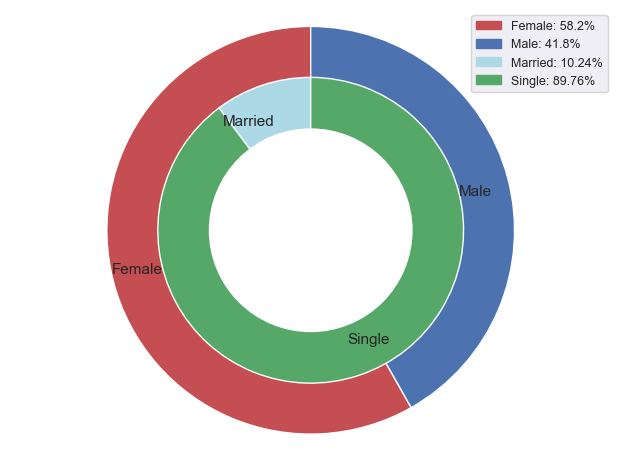

In [9]:
colors=['r','b']
colors2=['lightblue','g']

plt.pie(df[0], labels=['Female','Male'],colors=colors, startangle=90,frame=True,labeldistance=0.75)
plt.pie(df2[0],labels=['Married','Single'],colors=colors2,radius=0.75,startangle=90,labeldistance=0.75)
centre_circle = plt.Circle((0,0),0.5,color='black', fc='white',linewidth=0)

legend_elements = [Patch([0], [0], color='r', lw=1, label='Female: '+str(round(df.loc['F','%']*100,2))+'%'),
                  Patch([0], [0], color='b', lw=1, label='Male: '+str(round(df.loc['M','%']*100,2))+'%'),
                  Patch([0], [0], color='lightblue', lw=1, label='Married: '+str(round(df2.loc['C','%']*100,2))+'%'),
                  Patch([0], [0], color='g', lw=1, label='Single: '+str(round(df2.loc['S','%']*100,2))+'%')]
                    
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.axis('equal')
plt.tight_layout()
plt.legend(handles=legend_elements,prop={'size': 9})
plt.show()

In [10]:
#customers account visualization.
customers_accounts=pd.merge(data_customers,data_accounts,left_on='Cus_ID',right_on='Cus_ID',how='inner') #inner to select all clients with accounts

df1=customers_accounts.pivot_table(index='Cus_ID',aggfunc='size') #historical

df2=customers_accounts[customers_accounts.Acc_Sol>0] #active accounts is deffined as a account with possitive sold
df2=df2.pivot_table(index='Cus_ID',aggfunc='size') #active.
df2=df2.to_frame().pivot_table(index=0,aggfunc='size').to_frame()

df3=customers_accounts.pivot_table(index='Cus_ID',values='Days_impay',aggfunc='mean')


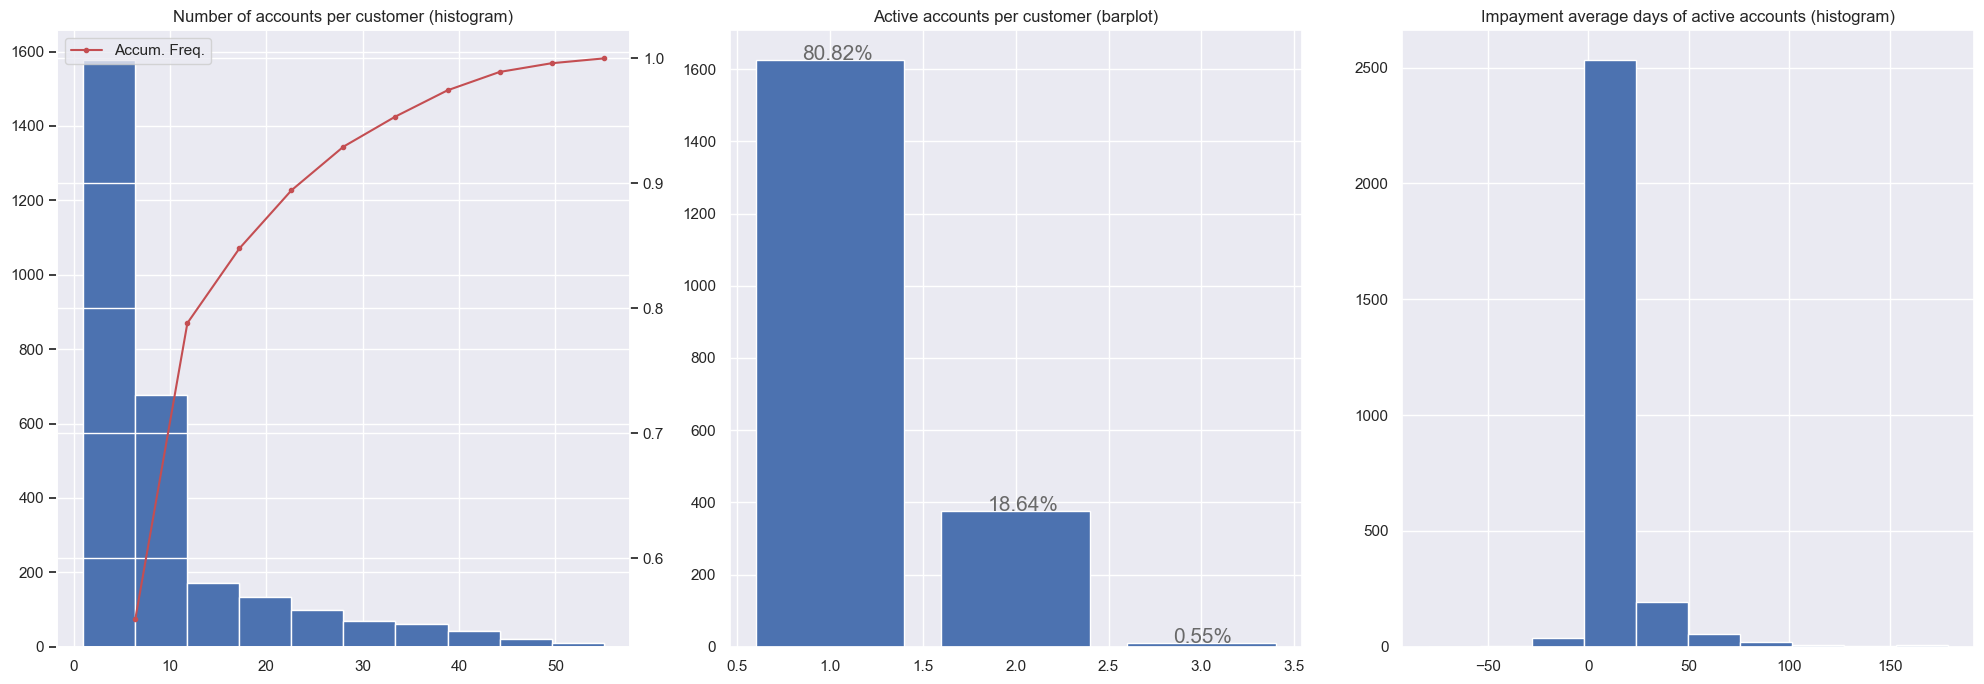

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=3,figsize=(20,7))
axes[0].hist(df1,color='b')
axes[0].set_title('Number of accounts per customer (histogram)')
(n, bins, patches) =axes[0].hist(df1)
n_ac=n.cumsum()/n.sum()
axes[0]=axes[0].twinx()
axes[0].plot(bins[1:],n_ac,'.-',color='r',label='Accum. Freq.')
axes[0].legend()

axes[1].bar(df2.index,df2[0])
axes[1].set_title('Active accounts per customer (barplot)')
totals = []
for i in axes[1].patches:
    totals.append(i.get_height())
total = sum(totals)
for i in axes[1].patches:
    axes[1].text(i.get_x()+0.25, i.get_height()+.5, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15,
                color='dimgrey')
    
axes[2].hist(df3.Days_impay)
axes[2].set_title('Impayment average days of active accounts (histogram)')

plt.tight_layout()

In [12]:
#customers_accounts.Acc_Am.plot.hist() #outliers detected

(81.0, 0.0)

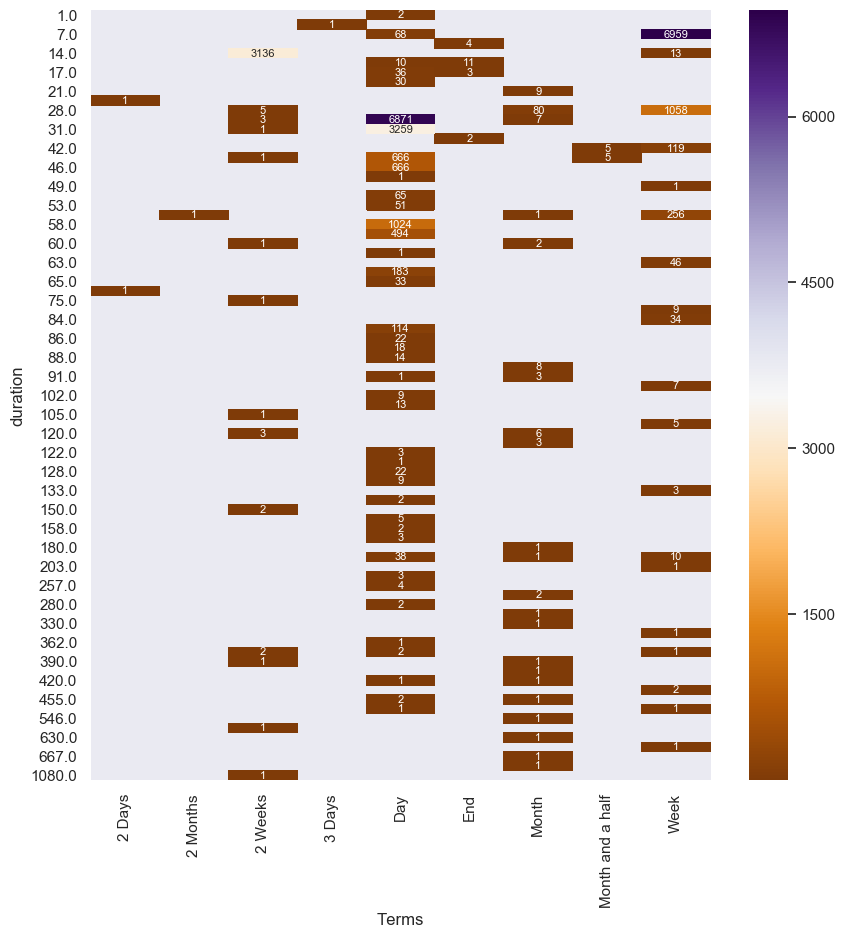

In [13]:
#number of accounts by p.termn and duration
df=customers_accounts.pivot_table(index='duration',columns='Terms',values='Acc_Am',aggfunc='size')

plt.figure(figsize=(10,10))
ax = sns.heatmap(round(df,0), annot=True,cmap="PuOr",vmin=df.min().min(),vmax=df.max().max(),annot_kws={"fontsize":8},fmt='g')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
#this plot is not necessary

In [14]:
customers_accounts.Terms.unique()  #['2 Weeks','Day','Week']

array(['Day', '2 Weeks', 'Week', 'Month', 'End', 'Month and a half',
       '2 Months', '3 Days', '2 Days'], dtype=object)

C:\Users\user\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\user\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Text(0.5, 1.0, 'Hitogram of days of impayment per account (paymen terms: Day, 2 weeks, and week)')

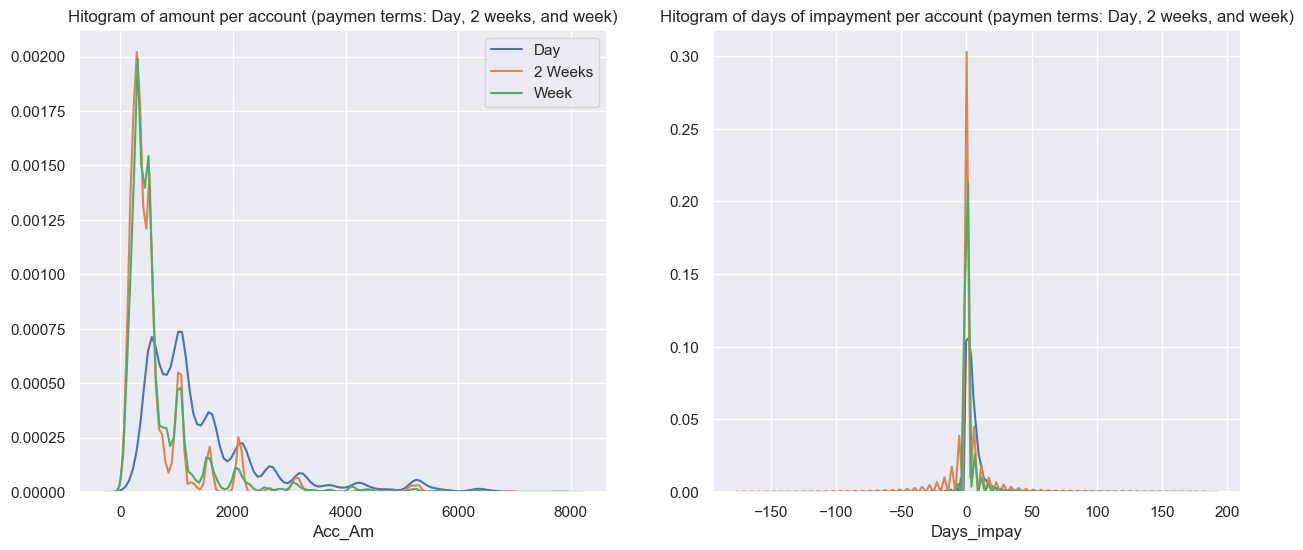

In [15]:
df=customers_accounts[customers_accounts.Terms.isin(['2 Weeks','Day','Week'])]
df_sel=df[['Acc_ID','Terms','Acc_Am','Days_impay']]

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,6))
for term in df_sel.Terms.unique():
    df_plot=df_sel[df_sel.Terms==term]
    df_plot=df_plot[df_plot.Acc_Am<8000]
    axes[0]=sns.distplot(df_plot['Acc_Am'],label=term, hist = False, kde = True,kde_kws = {'linewidth': 1.5},ax=axes[0])
axes[0].set_title('Hitogram of amount per account (paymen terms: Day, 2 weeks, and week)')

for term in df_sel.Terms.unique():
    df_plot=df_sel[df_sel.Terms==term]
    axes[0]=sns.distplot(df_plot['Days_impay'], hist = False, kde = True,kde_kws = {'linewidth': 1.5},ax=axes[1])
axes[1].set_title('Hitogram of days of impayment per account (paymen terms: Day, 2 weeks, and week)')

In [16]:
#timeframe
#from 2017-01-02 to 2017-11-04
# data schedule must be modified


In [17]:
#merging datasets
df_acc_payment=pd.merge(payments,data_accounts,left_on='Pec_ID',right_on='Acc_ID',how='inner')
df_acc_payment.Pay_Date=pd.to_datetime(df_acc_payment.Pay_Date, format="%Y-%m-%d")

df_acc_sched=pd.merge(sche_payments,data_accounts,left_on='Pec_ID',right_on='Acc_ID',how='inner') #correctig datasched
df_acc_sched.Sche_Date=pd.to_datetime(df_acc_sched.Sche_Date, format="%Y-%m-%d")
df_acc_sched=df_acc_sched[df_acc_sched.Sche_Date<=datetime.strptime('2017-11-04', '%Y-%m-%d')]

df1=df_acc_payment[['Cus_ID_x','Pay_Total_payment','Pay_Date']]
df1['type']='payment'
df1.columns=['Cus_ID','amount','Date','type']
df2=df_acc_sched[['Cus_ID_x','Sche_Total_payment','Sche_Date']]
df2['type']='Schedule'
df2.columns=['Cus_ID','amount','Date','type']

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [18]:
data=pd.concat([df1,df2])
data_pivot=data.pivot_table(index=['Cus_ID','Date'],columns='type',values='amount',aggfunc='sum').reset_index()
data_pivot.Schedule=data_pivot.Schedule.replace(0,np.NaN) #converting 0 values to nan. the conversion is because 0 just points the begining of an account but not an actual peyment

In [19]:
#conditional cleaning of schedule and payment columns if there is one of them, the other is 0
#for row in data_pivot.index():

indexes=data_pivot[~((data_pivot.payment.isnull())&(data_pivot.Schedule.isnull()))].index
data_pivot.loc[indexes]=data_pivot.loc[indexes].fillna(0)

In [20]:
data_pivot=data_pivot.assign(diff=data_pivot.payment-data_pivot.Schedule)
#data_final=data_pivot.pivot_table(index='Cus_ID',columns='Date',values='diff',aggfunc='sum')

def cases(due,payment):
    if payment==0:
        return -1
    elif due > payment:
        return -2
    elif (payment>0 and due>0 and payment/due>2):
        return 1
    elif (payment>0 and due==0):
        return 1
    elif payment>0:
        return 0

{'No payment':-2,'Payment':0,'Incomplete payment':-1,'Extreme payment':1}
data_pivot['category_payment'] = np.vectorize(cases)(data_pivot['Schedule'], data_pivot['payment'])
data_pivot=data_pivot[(data_pivot.Date>='2017-01-01')&(data_pivot.Date<='2017-11-01')]
data_pivot.fillna(value=pd.np.nan, inplace=True)

C:\Users\user\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


In [21]:
data_pivot_plot=data_pivot.pivot_table(index='Cus_ID',columns='Date', values='category_payment',aggfunc='mean')

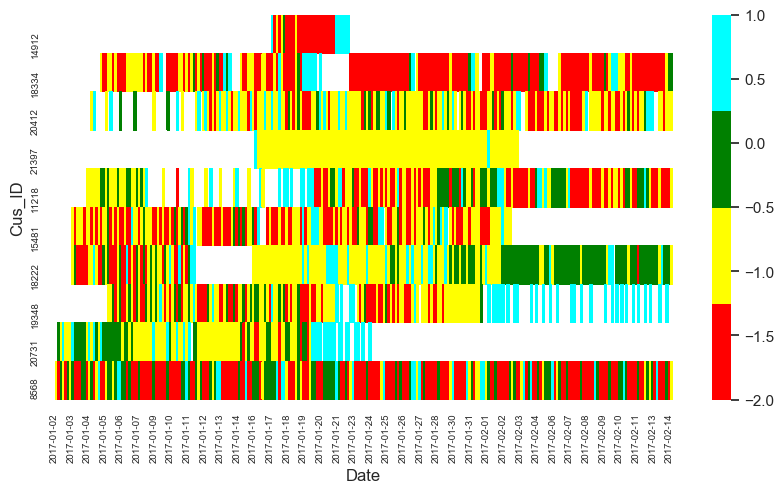

In [22]:
#list_sample_customers=[18111,20598,18562,20618,17587,21165,12218,20720,18389,19956] 18275,9558,17861,
list_sample_customers=random.sample(list(data_pivot.Cus_ID.unique()),10)
data_sample=data_pivot_plot.loc[list_sample_customers,]
cMap =ListedColormap(['Red', 'yellow', 'green','cyan'])
plt.figure(figsize=(10,5))
ax = sns.heatmap(data_sample,cmap=cMap,annot_kws={"fontsize":8},fmt='g')
ax.set_facecolor('white')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

ax.set_xticklabels(pd.Series(list(data_sample.columns.unique())).dt.strftime('%Y-%m-%d'))

ax.xaxis.set_tick_params(labelsize=7)
ax.yaxis.set_tick_params(labelsize=7)
plt.show() 

In [23]:
gatito=list(data_pivot.Cus_ID.unique())
list_of_selected_customers=[]
for Id in gatito:
    if data_pivot[data_pivot.Cus_ID==Id].shape[0]>=250:
        list_of_selected_customers.append(Id)
len(list_of_selected_customers)

221

In [39]:
data_pivot.Cus_ID.unique()

array([ 8521,  8545,  8548, ..., 21906, 21909, 21911], dtype=int64)

In [56]:
data_pivot['Time_vector']=""
data_pivot=data_pivot.reset_index(drop=True)
list_of_numbers=[]
for ID in list(data_pivot.Cus_ID.unique()):
    time_value=0
    for row in list(data_pivot[data_pivot.Cus_ID==ID].index):
        list_of_numbers.append(time_value)
        time_value+=1

In [67]:
data_pivot['Time_vector']=list_of_numbers


In [24]:
data_customers[data_customers.Cus_OID==23913716]

,Cus_ID,Cus_OID,Agency,Zone,cli_id,Sex,Marital_Status,age
1320,18246,23913716.0,B,46,18246,F,S,45.375648


In [25]:
#plot(501011,'2017-01-17','2017-11-01') #id=19598

In [26]:
#plot(511264,'2017-01-17','2017-11-01')  #ID 19568

In [27]:
#plot(23913716,'2017-01-17','2017-02-10') #ID 18246

In [68]:
#extracting samples. 
#18111,20598,18562,20618,17587,21165,12218,20720,18389,19956
#sample_list_IDs=[19598,19568,18246,18111,20598,18562,20618,17587,21165,12218,20720,18389,19956]
df_sample=data_pivot[data_pivot.Cus_ID.isin(list_of_selected_customers)]
df_sample.head(10)

type,Cus_ID,Date,Schedule,payment,diff,category_payment,Time_vector
731,8568,2017-01-02,NaN,NaN,NaN,NaN,0
732,8568,2017-01-03,40.0,0.0,-40.0,-1.0,1
733,8568,2017-01-04,40.0,30.0,-10.0,-2.0,2
734,8568,2017-01-05,40.0,60.0,20.0,0.0,3
735,8568,2017-01-06,40.0,0.0,-40.0,-1.0,4
736,8568,2017-01-07,40.0,30.0,-10.0,-2.0,5
737,8568,2017-01-09,40.0,60.0,20.0,0.0,6
738,8568,2017-01-10,64.0,0.0,-64.0,-1.0,7
739,8568,2017-01-11,64.0,100.0,36.0,0.0,8
740,8568,2017-01-12,64.0,50.0,-14.0,-2.0,9


In [69]:
df_sample.to_csv('df_sample.csv', sep=',',index=False)

C:\Users\user\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:45: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<function matplotlib.pyplot.show(*args, **kw)>

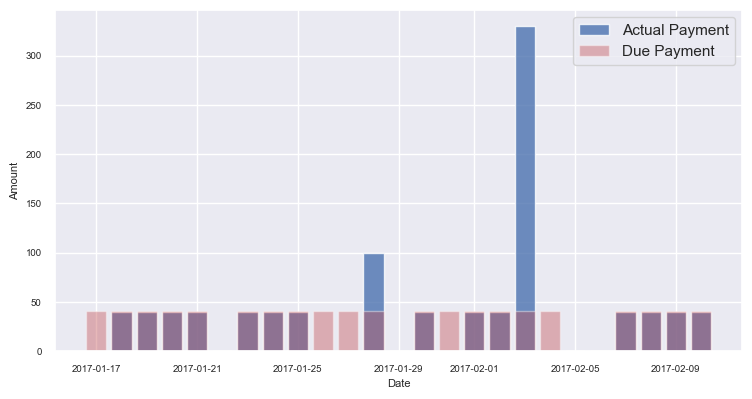

In [30]:
def plot(OID,Start_date,End_date):
    Start_date=datetime.strptime(Start_date, '%Y-%m-%d')
    End_date=datetime.strptime(End_date, '%Y-%m-%d')
    payment=payment_customer[(payment_customer.Cus_OID==OID)&((payment_customer.Pay_Date>=Start_date)&
                (payment_customer.Pay_Date<=End_date))][['Pay_Date','Pay_Total_payment','Cod_type']]
    schedule=sche_payment_customer[(sche_payment_customer.Cus_OID==OID)&((sche_payment_customer.Sche_Date>=Start_date)&
                (sche_payment_customer.Sche_Date<=End_date))][['Sche_Date','Sche_Total_payment','Cod_type']]

    payment=payment.groupby(['Pay_Date','Cod_type'])['Pay_Total_payment'].agg(Pay_Total_payment='sum')
    payment.reset_index(inplace=True)
    payment.columns = ['Date', 'Cod','Amount']
    schedule=schedule.groupby(['Sche_Date','Cod_type'])['Sche_Total_payment'].agg(Sche_Total_payment='sum')
    schedule.reset_index(inplace=True)
    schedule.columns = ['Date', 'Cod','Amount']
    main_table=pd.concat([payment,schedule])
    main_table=main_table.pivot_table('Amount', ['Date'], 'Cod')
    main_table.reset_index(inplace=True)
    ## creating a time vector
    datex=Start_date
    datelist=list()
    while datex<=End_date:
        datelist.append(datex)
        datex+= timedelta(days=1)  
    datelist
    Dates={'Dates':datelist} 
    Dates=pd.DataFrame(Dates)
    ##merging time vector and main table
    main_table=pd.merge(left=Dates,right=main_table,how='outer',left_on='Dates', right_on='Date')[['Dates','efect','pres']]
    main_table.fillna(0, inplace=True)
    #creating errors plot
    main_table['dev']=main_table['pres']-main_table['efect']
    
    fig = plt.figure(figsize=(12, 6))
    grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
    main_ax = fig.add_subplot(grid[:-1, 1:])

    main_ax.bar(main_table['Dates'], main_table['efect'], align='center', alpha=0.8,color='b',label='Actual Payment')
    main_ax.bar(main_table['Dates'], main_table['pres'], align='center', alpha=0.4,color='r',label='Due Payment')
    main_ax.legend()
    main_ax.xaxis.set_tick_params(labelsize=7)
    main_ax.yaxis.set_tick_params(labelsize=7)
    main_ax.set_xlabel('Date',fontsize=8)
    main_ax.set_ylabel('Amount',fontsize=8)
    
    plt.tight_layout()
    return plt.show
plot(511264,'2017-01-17','2017-02-10')  #ID 19568